In [3]:
import numpy as np
import math
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [176]:
class PDE:
    def __init__(self, xi, tpoints=201, xpoints=512, trange=(0,20), xrange=(-30, 30), seed=0):
        """
        xi is a 2d matrix where each entry corresponds to a coefficient of a term, 
        where the 1st axis corresponds to the order of the space partial derivative
        and the 2nd axis corresponds to the degree of the function.
        For example, ut = 1+2u+3u**2 + 4ux+5uxu+6uxu**2 + 7uxx+8uxxu+9uxxu**2
        becomes [[1, 2, 3],[4, 5, 6],[7, 8, 9]]
        """
        
        self.rng = np.random.RandomState(seed)
        
        self.xi = xi
        self.max_order = self.xi.shape[0]-1 #the minus 1 is because it goes from 0 to max, inclusive
        self.max_degree = self.xi.shape[1]-1 #the minus 1 is because it goes from 0 to max, inclusive
        
        self.tpoints = tpoints
        self.xpoints = xpoints
        self.trange = trange
        self.xrange = xrange
        
        self.dt = (self.trange[1]-self.trange[0])/ self.tpoints #time steps
        self.dx = (self.xrange[1]-self.xrange[0])/ self.xpoints #space step
        
        self.u = self.init_u()
        self.simulated = False
        
    def init_u(self):
        #makes one wavelength of cos, from 1 crest to the next
        xarr = np.linspace(self.xrange[0], self.xrange[1], self.xpoints)
        k = 2*np.pi/(self.xrange[1] - self.xrange[0])
        phi = np.pi
        u0 = np.cos(k*xarr+phi)
        uempty = np.full((self.xpoints,), np.nan, dtype=float)
        return np.vstack([u0]+[uempty]*(self.tpoints-1))
    
    def __repr__(self):
        rep = 'ut ='
        for order in range(self.max_order+1):
            for degree in range(self.max_degree+1):
                coef = self.xi[order, degree]
                if coef == 0:
                    term = ''
                else:
                    #coefficient factor
                    if coef > 0:
                        term = ' + ' + str(coef)
                    elif coef < 0:
                        term = ' - ' + str(-coef)
                    #partial deriv factor
                    if order > 0:
                        term += 'u' + 'x'*order
                    else: 
                        pass
                    #function factor
                    if degree == 1:
                        term += 'u'
                    elif degree > 1:
                        term += 'u**'+degree
                    else: 
                        pass
                rep += term
        if rep == 'ut =':
            rep = 'ut = 0'
        rep += '\n\twith xpoints='+str(self.xpoints)+' in '+str(self.xrange)
        rep += '\n\tand with tpoints='+str(self.tpoints)+' in '+str(self.trange)
        return rep
        
        
    def get_dxs(self, point, npoints_behind, npoints_ahead):
        diffs_behind = list(self.dxs[point-npoints_behind:point])
        diffs_ahead = list(self.dxs[point:point+npoints_ahead])
        return diffs_behind + diffs_ahead
    
    def get_du_x(self, time, point):
        ugrid = self.u[time]
        if point >= ugrid.shape[0]:
               raise IndexError("Index too large")
        elif point < 0:
            raise IndexError("Index too small")
        else:
            return ugrid[point+1] - ugrid[point]
    def get_dus_x(self, time, point, npoints_behind, npoints_ahead):
        ugrid = self.u[time]
        diffs_behind = []
        for i in range(npoints_behind, 0, -1):
            diffs_behind.append(self.get_du_x(time, point-i))
        diffs_ahead = []
        for i in range(0, npoints_ahead, 1):
            diffs_ahead.append(self.get_du_x(time, point+1))
        return diffs_behind + diffs_ahead
    
    def get_x_deriv_forward(self, time, point, order):
        deriv = self.get_du_x(time, point+order-1) / self.dx**order
        print(str(order)+'_0 '+str(point)+': '+str(self.get_du_x(time, point+order-1))+'/'+str(self.dx)+'**'+str(order))
        for i in range(order-1, 0, -1):
            print(str(order)+' '+str(point)+': '+str(self.get_x_deriv(time, point+i-1, order-i) / self.dx**i))
            deriv -= self.get_x_deriv(time, point+i-1, order-i) / self.dx**i
        return deriv
    def get_x_deriv_backward(self, time, point, order):
        deriv = 0
        for i in range(1, order, +1):
            if i == 1:
                sign = 1
            else:
                sign = -1
            deriv += sign*self.get_x_deriv(time, point-i+1, order-i) / self.dx**i
        deriv -= self.get_du_x(time, point-order) / self.dx**order
        return deriv
    def get_x_deriv_middle(self, time, point, order, verbose=False):
        if order < 1:
            raise ValueError("Order of a derivative cannot be less than one")
        binomial = lambda n, k: math.factorial(n)/math.factorial(k)/math.factorial(n-k)
        ugrid = self.u[time]
        deriv = 0
        stringvar = '('
        stringnum = '('
        for i in range(0, order+1, +1):
            if point+order-2*i >= ugrid.shape[0]:
                raise IndexError("Index too large")
            elif point+order-2*i < 0:
                raise IndexError("Index too small")
            else:
                stringvar += ' + '+str((-1)**i)+' * '+str(order)+'C'+str(i)+' * u[point+'+str(order-2*i)+']'
                stringnum += ' + '+str((-1)**i)+' * '+str(binomial(order, i))+' * '+str(ugrid[point+order-2*i])
                deriv += (-1)**i * binomial(order, i) * ugrid[point+order-2*i] 
        stringvar += ')/(2 * dx)**'+str(order)
        stringnum += ')/(2 * '+str(self.dx)+')**'+str(order)
        if verbose==True:
            print(str(stringvar)+' = '+str(stringnum)+' = '+str(deriv))
        print('mid')
        return deriv/(2**order * self.dx**order)
    def get_x_deriv(self, time, point, order):
        deriv = 0
        try:
            deriv = self.get_x_deriv_middle(time, point, order)
        except IndexError:
            try:
                deriv = self.get_x_deriv_forward(time, point, order)
            except IndexError:
                deriv = self.get_x_deriv_backward(time, point, order)
        return deriv
    def get_t_deriv(self, time, point):
        deriv = 0
        for order in range(self.max_order+1):
            for degree in range(self.max_degree+1):
                coef = self.xi[order, degree]
                xderiv = self.get_x_deriv(time, point, order)
                u = xderiv*self.u[time, point]
                try: 
                    deriv += coef * u**degree * xderiv
                except FloatingPointError:
                    print("time = "+str(time))
                    print("coef = "+str(coef))
                    print("u = "+str(u))
                    print("u**"+str(degree)+" = "+str(u**degree))
                    print("ux = "+str(xderiv))
                    raise
        return deriv
    
    def sim_next_point(self, time, point):
        u_curr = self.u[time, point]
        for order in range(self.max_order+1):
            for degree in range(self.max_degree+1):
                u_next = u_curr + self.dt*self.get_t_deriv(time, point)
        return u_next
    def sim_next_grid(self, time):
        next_grid = np.empty((self.xpoints,), dtype=float)
        for point in range(self.xpoints):
            next_grid[point] = self.sim_next_point(time, point)
        return next_grid
    def sim(self, force=False):
        if self.simulated == False or force == True:
            if force == True: print("Resimulating PDE from first step")
            for time in range(self.tpoints-1):
                self.u[time+1] = self.sim_next_grid(time)
            self.simulated == True
            return self.u
        else:
            print("PDE already simulated")
            return self.u

In [177]:
kdv_xi = np.zeros((4, 2))
kdv_xi[3,0] = -1
kdv_xi[1,1] = -6
kdv = PDE(kdv_xi, xrange=(-np.pi, np.pi))
print(kdv)

ut = - 6.0uxu - 1.0uxxx
	with xpoints=512 in (-3.141592653589793, 3.141592653589793)
	and with tpoints=201 in (0, 20)


In [178]:

print()
print(kdv.get_x_deriv_forward(0, 0, 2))
print()
print(kdv.get_x_deriv_forward(0, 0, 3))


2_0 0: -0.000226768034995/0.01227184630308513**2
1_0 0: -7.55931545482e-05/0.01227184630308513**1
2 0: -0.501952537826
1_0 0: -7.55931545482e-05/0.01227184630308513**1
-1.0038291873

3_0 0: -0.000377908631219/0.01227184630308513**3
mid
3 0: -81.8024530853
mid
2_0 0: -0.000226768034995/0.01227184630308513**2
1_0 0: -7.55931545482e-05/0.01227184630308513**1
2 0: -0.501952537826
1_0 0: -7.55931545482e-05/0.01227184630308513**1
3 0: -81.7993611157
2_0 0: -0.000226768034995/0.01227184630308513**2
1_0 0: -7.55931545482e-05/0.01227184630308513**1
2 0: -0.501952537826
1_0 0: -7.55931545482e-05/0.01227184630308513**1
-40.8811296751


forw
1_0 0: -0.00615988439565
-----
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid
mid


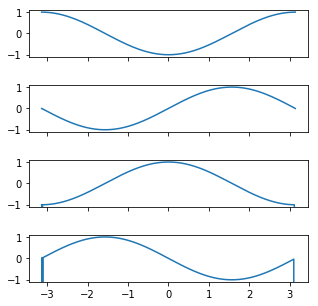

In [171]:
#print(kdv.get_x_deriv_middle(0, 512//4, 1, verbose=True))

fig, axes = plt.subplots(kdv.max_order+1, figsize=(5,5), sharex=True, sharey=True)
x = np.linspace(kdv.xrange[0], kdv.xrange[1], kdv.xpoints)
time = 0
y0 = kdv.u[time]
axes[0].plot(x, y0)
ylims = axes[0].get_ylim()
y = [[kdv.get_x_deriv(time, point, order) for point in range(kdv.xpoints)] for order in range(1, kdv.max_order+1)]
for i in range(len(y)):
    axes[i+1].plot(x, y[i])
axes[0].set_ylim(ylims[0], ylims[1])
plt.subplots_adjust(hspace=0.6)
plt.show()

In [160]:
np.seterr(all='raise')
np.seterr(under='ignore')
for time in range(kdv.tpoints-1):
    print(str(time)+": u = "+str(kdv.u[time, 0]))
    kdv.u[time+1] = kdv.sim_next_grid(time)
    if np.any(np.isnan(kdv.u[time+1])):
        print(kdv.u[time+1])

0: u = 1.0


ValueError: Order of a derivative cannot be less than one

### TO DO
- rewrite get_x_deriv and it's forward/backward/middle versions to have less nested steps
- expand possible equations to include more non-linearity, like ut = sin(ux)
- make it possible to have an irregular grid spacing
- add boundary conditions